In [7]:
import sys
sys.path
sys.path.append("src/")
from estimate_pop_parameters import *
import calculate_theta_from_fastsimcoal_output as fscoal

# 1. Estimating population parameters from UCE allele alignments
Here I wrote some functions that help extracting useful summary statistics from UCE allele alignments and plotting them.

### 1. Getting all variable positions from allele alignments
The underlying data are multiple sequence alignments containing the UCE allele sequences of 10 diploid individuals (=20 sequences). The data looks like this:

In [8]:
%%bash
ls ../data/topaza-uce-allele-alignments/ | head -n 10

uce-101_phased.fasta
uce-1035_phased.fasta
uce-1038_phased.fasta
uce-103_phased.fasta
uce-1043_phased.fasta
uce-1055_phased.fasta
uce-1061_phased.fasta
uce-1064_phased.fasta
uce-1068_phased.fasta
uce-1069_phased.fasta


In [9]:
%%bash
head -n 60 ../data/topaza-uce-allele-alignments/uce-101_phased.fasta

>T_pella7_0
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGCAGTTACATTCTTGTT
GAACAAATCAATTAAATATACACTATACTGCATCTTTACACTGTATAATGTTGGGGGGTT
TTTGTGCTGAAGCAGTCTTGTACAGCTGGAC-AAAAAAAAATCCCTAGGAGGGTTCAGAG
ACCAGTTTAAGCTATGAGTTTTTGTAGTATCGGCAGCAACGGTAAACAATTCAGAAAATC
TGAGATGTTAAAGGGAAGGGAGGGACAGGGCTCTGCTGGTTTCAGTGCTTCTAAGGCTTG
GGCTTTATTTCCACCTTAAAATCTTTACCTGACCATGATCTGTTGTTCCATTACTGGAGG
GCAAAAATGGGAGGAATTGTCTGGGCTAAATTGCAATTAGCCAGCCCTGAGAGAGGCTGG
CACCAGTTAACTTGGGATATTGGAGTGAAAAGGCCCGTAATCAGCCTTCGGTCATGTAGA
ACAATGCATAAAATTAAATTGACATTAATGAATAATTGTGTAATGAAAATGGAAGAGGAG
AGTTAATTGCATGTTACAGTGAGTGTAATGCCTAGATAACCTTGCATTTAATGCTATTCT
TAGCCCTGCTGCCAAGACTTCTACAGAGCCTCTCTCTGCAGGAAGTCATTAAAGCTGTGA
GTAGATAATGCAGGCTCAGTGAAACCTAAGTGGCAACAATATAACAAGAGTTTCTTTCAG
ACCTTAGTGTTTTCAGAAAAAAGGGGCATGTTGAGGTAATTTGTACACATCGAAATGAAA
ACAGGAAACTCGGAGCAATCTATTTGTAGTTTGTCCAGTTCCACAGAATTTTCAACTTGT
GTTGAAACTGAAGTTAATTCATATAATCAAAGACAAGACTAGCCATCAATGCTTGCAACA
CAGTAAGCATCCAGCTGTCTACAGATAAAACTTTGTTTTGTTAATCACCTACTACAGCAA
AGGATATAAANN

Before we continue we need to define a few variables:

In [10]:
input_dir = '../data/topaza-uce-allele-alignments'
aln_format = 'fasta'
min_num_seqs = 20
output_dir = '../results/plots'
outgroup = 'Florisuga'

Now we want to know which positions in the alignments contain polymorphisms and have data for all sequences. The following function does exactly that:

In [11]:
# get a list of all alignments
alignment_list = read_aln_in_folder(input_dir,aln_format)
# return a dictionary of all positions with missing data and another one only containing variable positions without missing data
valid_columns, snp_columns, removed_seqs = get_variable_positions(alignment_list,aln_format,min_num_seqs,outgroup)
print('done')

done


The resulting dictionary 'snp_columns' contains a list of all variable positions for each locus, here is a small excerpt:

In [12]:
dict(list(snp_columns.items())[0:10])

{'uce-101_phased.fasta': [621, 707, 777, 862, 868, 888],
 'uce-1035_phased.fasta': [135, 141, 148, 288, 308, 410, 528],
 'uce-103_phased.fasta': [62, 224, 394],
 'uce-1064_phased.fasta': [765],
 'uce-1068_phased.fasta': [451, 528, 720],
 'uce-1069_phased.fasta': [628],
 'uce-1162_phased.fasta': [737, 753, 839],
 'uce-1170_phased.fasta': [116, 144, 201, 280, 420, 633],
 'uce-1177_phased.fasta': [164, 219, 221, 225, 226, 228, 277, 300, 440],
 'uce-117_phased.fasta': [240, 241, 244, 438, 800, 845]}

From these variable positions (=SNPs) we eventually want to estimate theta, using Tajima's estimator. For this we need to compare every pair of sequences and count all differences and then divide by the total number of pairwise comparisons. Here we retrieve the total number of pairwise differences for our 20 sequences (minus all sequences which represent outgroup seqeunces and were removed by the previous function):

In [13]:
possible_combos = get_possible_combinations_for_n_sequences(int(min_num_seqs)-int(removed_seqs))
print(possible_combos)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16), (7, 17), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (8, 16), 

However, making all these pairwise comparisons can take an aweful long time. Here we use a shortcut, only comparing those positions which we have previously identified to be polymorphic and calculating how many pairwise differences would return a difference, based on the frequency of the SNP. Tajima's estimator is then calculated for each locus and corrected for the total alignment length.

In [14]:
locus_tajima_dict,locus_snp_count_dict = tajimas_estimator_per_locus(input_dir,aln_format,snp_columns,valid_columns,min_num_seqs,outgroup,possible_combos)
dict(list(locus_tajima_dict.items())[0:10])

{'uce-101_phased.fasta': 0.004750438186970694,
 'uce-1035_phased.fasta': 0.0029666045092388536,
 'uce-103_phased.fasta': 0.0006106819832310029,
 'uce-1064_phased.fasta': 0.0007982836900663574,
 'uce-1068_phased.fasta': 0.0009734390209984703,
 'uce-1069_phased.fasta': 0.0005838563713326521,
 'uce-1162_phased.fasta': 0.0016213203627704312,
 'uce-1170_phased.fasta': 0.00329020497087724,
 'uce-1177_phased.fasta': 0.006121472979435677,
 'uce-117_phased.fasta': 0.002730982846972905}

Now let's plot the calculated thetas for all loci and calculate the expected fraction of heterozygos sites within the ingroup:

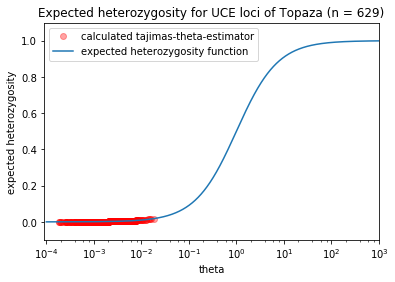

In [15]:
plot_expected_heterozyosity(locus_tajima_dict,output_dir)

We are also interested in the site frequency spectrum (SFS) across all loci within our ingroup. We can use the outgroup in order to guess which allele is the original state and which is the derived one. The function follows the following logic:

A) determine the ancestral state at each polymorphism:
    1. if outgroup allele also present in ingroup, take it as ancestral state
    2. if outgroup allele not present in ingroup, choose the most common ingroup allele as ancestral
    3. if all allele copies are equally common, choose one at random as ancestral
B) for all derived mutations, count by how many sequences those are shared

In [16]:
locus_derived_allele_counts_dict = get_fsf_stats(input_dir,aln_format,outgroup,locus_snp_count_dict)
dict(list(locus_derived_allele_counts_dict.items())[0:10])

{'uce-101_phased.fasta': [1, 1, 7, 1, 1, 1],
 'uce-1035_phased.fasta': [1, 8, 1, 1, 3, 1, 2],
 'uce-103_phased.fasta': [2, 1, 1],
 'uce-1064_phased.fasta': [2],
 'uce-1068_phased.fasta': [2, 2, 1],
 'uce-1069_phased.fasta': [2],
 'uce-1162_phased.fasta': [2, 2, 2],
 'uce-1170_phased.fasta': [3, 2, 3, 1, 2, 1],
 'uce-1177_phased.fasta': [16, 1, 1, 1, 1, 1, 5, 1, 1],
 'uce-117_phased.fasta': [17, 1, 1, 1, 7, 2]}

Now join all these values for each single locus into one global list and plot it as a histogram:

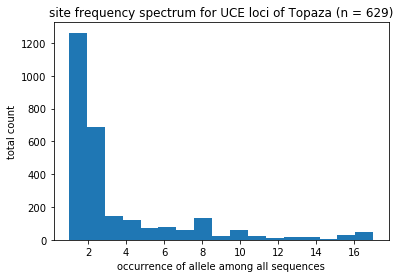

In [17]:
join_and_plot_sfs_data(locus_derived_allele_counts_dict,output_dir)

## Estimating theta from fastsimcoal sequence simulation output
In the course we applied abc methods to estimate theta from simulated data. Here I calculate theta using the Tajima estimator instead:

tajima estimated log(theta) = -2.666712
real log(theta) = -2.698970


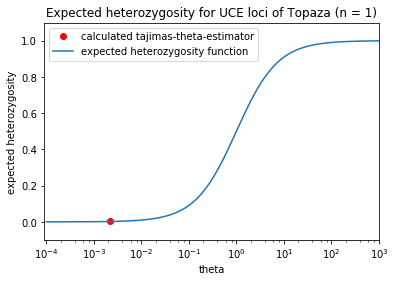

In [4]:
simcoal_out = '/Users/tobias/GitHub/abc_modeling_course_tjarno_2017/data/constsize_obs_1_1.arp'
alignment, num_seqs , input_dir, snp_length, alignment_length, mutation_rate, n_alleles = fscoal.convert_simcoal_output_to_fasta(simcoal_out)
possible_combos = get_possible_combinations_for_n_sequences(num_seqs)
aln_format = 'fasta'
min_num_seqs = num_seqs
outgroup = ''
name = alignment.split('/')[-1]

snp_columns = {}
snp_positions = list(range(0,snp_length))
snp_columns.setdefault(name,snp_positions)

valid_columns = {}
all_positions = list(range(0,alignment_length))
valid_columns.setdefault(name,all_positions)

locus_tajima_dict,locus_snp_count_dict = tajimas_estimator_per_locus(input_dir,aln_format,snp_columns,valid_columns,min_num_seqs,outgroup,possible_combos)
tajima = locus_tajima_dict[name]

print('tajima estimated log(theta) = %f'%math.log10(tajima))
print('real log(theta) = %f'%math.log10(2*n_alleles*mutation_rate))

plot_expected_heterozyosity(locus_tajima_dict,input_dir)

In [8]:
%%bash
cd ..
sh commands.sh

//Parameters for the coalescence simulation program : simcoal.exe
1 samples to simulate
//Deme sizes (haploid number of genes)
10000
//Sample sizes
20
//Growth rates
0
//Number of migration matrices : If 0 : No migration between demes
0
//Historical event: time, source, sink, migrants, new deme size, new growth rate, new migration matrix
0 historical events
//Number of independent chromosome
1 0
//Number of contiguous linkage blocks
1
//Per Block: Data type, No. of loci, Recombination rate to the right-side locus, plus optional parameters
DNA 10000 0 1.0e-07 0.5
fastsimcoal was invoked with the following command line arguments:
bin/fsc25221 -i constsize_obs.par -n 1 

Random generator seed : 201352

Deme sizes
Deme 0	10000


Sample sizes
Deme 0	20

Sample ages
Deme 0	0

Growth rates
Deme 0	0


Historical events
No historical events defined in input file ...


Number of independent loci to simulate : 1
with the same chromosomal structure

Number of linkage blocks to simulate in structur

mkdir: data/processed/: File exists
mkdir: data/processed/simulated_observed_data: File exists
ERROR: Output file 'sims_constsize_sampling1.txt' already exists! Use 'overWrite' to force replacement.

mkdir: data/processed/abc_sims: File exists
mkdir: data/processed/posterior: File exists


In [6]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

PDF('../results/plots/2D_joint_posterior_n_u.pdf',size=(600,500))

[Overview](../main.ipynb) | [2. Expectation value](./expected_value.ipynb)